# Определение возраста покупателей

Сетевой супермаркет внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
Контролировать добросовестность кассиров при продаже алкоголя.


**Цель:** 

Построить модель, которая по фотографии определит приблизительный возраст человека. В нашем распоряжении набор фотографий людей с указанием возраста. MAE модели должен быть не больше 8

**Краткое описание проделанной работы**

Проведен исследовательский анализ набора фотографий. Наблюдается дисбаланс возрастов и другие факторы которые могут негативно сказаться на качестве обучения модели.

Данные подготовлены к обучению: разделены на тренировочную и тестовую выборки в отношении 3:1 и отмасштабированны. К тренировочной выборке применена агрументация: горизонтальный флип.

Построена и обучена модель на основе ахитектуры ResNet50 с тремя дополнительными полносвязными слоями. 
Цель достигнута. MAE  6.3.

Приведены выводы и анализ результатов

## Исследовательский анализ данных

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
df = pd.read_csv('/datasets/faces/labels.csv')

datagen = ImageDataGenerator(rescale=1/255)

datagen_flow = datagen.flow_from_dataframe(
    dataframe=df,
    directory='/datasets/faces/final_files/',
    x_col='file_name',
    y_col='real_age',
    target_size=(150, 150),
    batch_size=16,
    class_mode='raw',
    seed=12345) 

Found 7591 validated image filenames.


In [3]:
df.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


In [4]:
df.isna().sum()

file_name    0
real_age     0
dtype: int64

In [5]:
df.duplicated().sum()

0

In [6]:
df.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


график распределения возраста в выборке


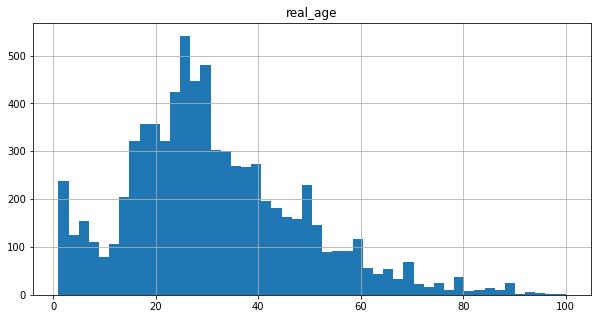

In [7]:
df.hist(bins=50, figsize=(10,5))
print('график распределения возраста в выборке')

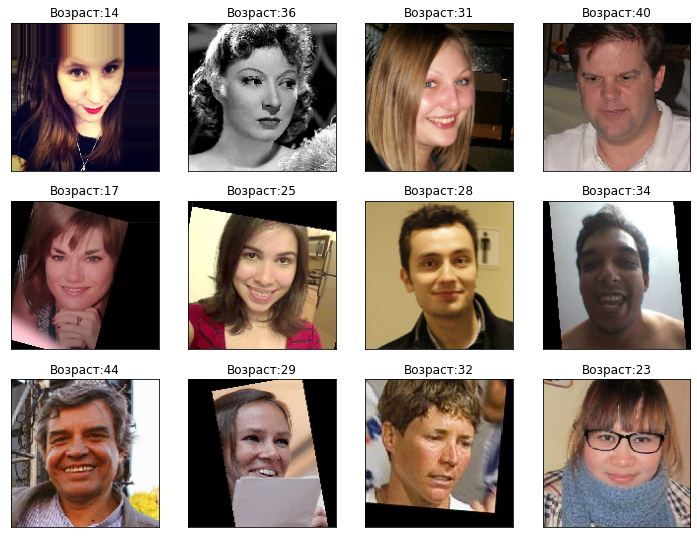

In [7]:
fig = plt.figure(figsize=(10,10))
for i in range(12):
    fig.add_subplot(4, 4, i+1)
    plt.title('Возраст:'+str(datagen_flow[5][1][i]))
    plt.imshow(datagen_flow[5][0][i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

**Промежуточные выводы:**

Данные загружены и изучены. 

Наблюдается дисбаланс возрастов. В исходных данных больше всего фото людей от 20 до 30. Фото возрастов старше 60 и возрастов около 10 лет меньше всего. Дисбаланс мжет сказаться на качестве обучения

По картинкам выше можно сказать, что возраст проставлен правдоподобно и к данным, видимо, уже применяли аргументацию.

На фото встречаются мешающие предметы: очки, другие аксессуары (шарф, например), разные предметы, которые держит человек и они закрывают часть лица (листок бумаги)

Есть черно-белые фото

На графике прям в глаза пики в "круглые" возраста (30, 40, 50,... лет). Возможно, для части людей возраст не точный, а округлённый
    
    

## Обучение модели

```python

from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import ResNet50
import numpy as np
import pandas as pd
 
def load_train(path):
    df = pd.read_csv('/datasets/faces/labels.csv')
    train_datagen = ImageDataGenerator(validation_split=0.25,
                                       rescale=1/255.,
                                       horizontal_flip=True
                                       )
    train_datagen_flow = train_datagen.flow_from_dataframe(
        dataframe=df,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        shuffle=False,
        seed=12345) 
 
    return train_datagen_flow



def load_test(path):
    df = pd.read_csv('/datasets/faces/labels.csv')
    test_datagen = ImageDataGenerator(validation_split=0.25,
                                      rescale=1/255.)
    test_datagen_flow = test_datagen.flow_from_dataframe(
        dataframe=df,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        shuffle=False,
        seed=12345) 
 
    return test_datagen_flow

 
 
def create_model(input_shape):
 
    backbone = ResNet50(input_shape=input_shape,
                    weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5', 
                    include_top=False)
 
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(240, activation='relu'))
    model.add(Dense(120, activation='relu')) 
    model.add(Dense(1, activation='relu')) 
    
    optimizer = Adam(learning_rate=0.0005) 
    model.compile(optimizer=optimizer, loss='mean_squared_error',
                  metrics=['mae'])
 
    return model
 
 
def train_model(model, train_data, test_data, batch_size=None, epochs=15,
               steps_per_epoch=None, validation_steps=None):
 
    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size,
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)
 
    return model

 
```

```

Train for 178 steps, validate for 60 steps
Epoch 1/15
2023-08-13 21:20:44.926953: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2023-08-13 21:20:46.117810: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
178/178 - 64s - loss: 215.4637 - mae: 11.0601 - val_loss: 315.1797 - val_mae: 13.2719
Epoch 2/15
178/178 - 39s - loss: 123.9411 - mae: 8.4366 - val_loss: 1108.9529 - val_mae: 29.5368
Epoch 3/15
178/178 - 40s - loss: 100.2675 - mae: 7.6598 - val_loss: 448.3371 - val_mae: 16.1761
Epoch 4/15
178/178 - 41s - loss: 86.3183 - mae: 7.0421 - val_loss: 247.0063 - val_mae: 11.7628
Epoch 5/15
178/178 - 38s - loss: 68.2512 - mae: 6.2741 - val_loss: 102.5966 - val_mae: 7.6607
Epoch 6/15
178/178 - 38s - loss: 53.6626 - mae: 5.5729 - val_loss: 94.4751 - val_mae: 7.2980
Epoch 7/15
178/178 - 37s - loss: 42.6537 - mae: 4.9958 - val_loss: 86.2699 - val_mae: 7.0612
Epoch 8/15
178/178 - 38s - loss: 34.7550 - mae: 4.5039 - val_loss: 110.8588 - val_mae: 7.8401
Epoch 9/15
178/178 - 38s - loss: 30.4187 - mae: 4.2149 - val_loss: 110.7540 - val_mae: 8.2521
Epoch 10/15
178/178 - 38s - loss: 30.6903 - mae: 4.1952 - val_loss: 92.8121 - val_mae: 7.2868
Epoch 11/15
178/178 - 39s - loss: 22.3171 - mae: 3.6246 - val_loss: 74.8417 - val_mae: 6.4861
Epoch 12/15
178/178 - 40s - loss: 16.9172 - mae: 3.1334 - val_loss: 88.0431 - val_mae: 7.1153
Epoch 13/15
178/178 - 40s - loss: 14.6372 - mae: 2.8981 - val_loss: 69.2905 - val_mae: 6.2954
Epoch 14/15
178/178 - 38s - loss: 13.9598 - mae: 2.8344 - val_loss: 83.3410 - val_mae: 6.9938
Epoch 15/15
178/178 - 37s - loss: 14.2743 - mae: 2.8189 - val_loss: 69.4924 - val_mae: 6.3171
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
60/60 - 9s - loss: 69.4924 - mae: 6.3171
Test MAE: 6.3171
```

## Анализ обученной модели

**Выводы:**

Данные загружены и изучены. Наблюдается дисбаланс возрастов. В исходных данных больше всего фото людей от 20 до 30. Фото возрастов старше 60 и возрастов около 10 лет меньше всего. Дисбаланс мжет сказаться на качестве обучения

Построена и обучена модель на основе ахитектуры ResNet50 с тремя дополнительными полносвязными слоями.

Цель добиться среднего квадратичного отклонения менее 8-ми лет достигнута. MAE обученной модели 6.3.

Такая точность подходит для определения возрастных групп с целью предлагать им определенные товары. А вот с контролем за продажей алкоголя, полностью доверять модели нельзя, модель может частично помочь с этой задачей. Модель создана, чтобы быть в данном случае дополнительным помощником в поимке плохих кассиров.

**Для дальнейшей работы (что можно улучшить):**

-Использовать дополнительные стратегии аргументации данных;

-Для задачи контроля кассиров: исследовать метрику на интересущем нас возрастном интервале (13-летний и 18-летний отличаются друг от друга в разы сильнее, чем 73-летний и 78-летний, так что есть подозрения, что бОльший вклад в ошибку внесли именно люди старшего возраста)